In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import matplotlib.pyplot as plt
import seaborn as sns   
from torchinfo import summary

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
LOAD_EDM = True

In [2]:
import torch
import dnnlib
import pickle

model_root = '/workspace/localizing-edm/workdir/pretrained_models'

if LOAD_EDM:
    model_file = f'{model_root}/edm-cifar10-32x32-uncond-ve.pkl' 
else:
    model_file = f'{model_root}/baseline-cifar10-32x32-uncond-ve.pkl' 
device = torch.device('cuda')
with dnnlib.util.open_url(model_file) as f:
    net = pickle.load(f)['ema'].to(device)

net

EDMPrecond(
  (model): SongUNet(
    (map_noise): FourierEmbedding()
    (map_augment): Linear()
    (map_layer0): Linear()
    (map_layer1): Linear()
    (enc): ModuleDict(
      (32x32_conv): Conv2d()
      (32x32_block0): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
        (skip): Conv2d()
      )
      (32x32_block1): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block2): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block3): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (16x16_down): UNetBlock(
        (norm0): GroupNorm()


In [3]:
summary(net)

Layer (type:depth-idx)                   Param #
EDMPrecond                               --
├─SongUNet: 1-1                          --
│    └─FourierEmbedding: 2-1             --
│    └─Linear: 2-2                       (2,304)
│    └─Linear: 2-3                       (131,584)
│    └─Linear: 2-4                       (262,656)
│    └─ModuleDict: 2-5                   --
│    │    └─Conv2d: 3-1                  (3,584)
│    │    └─UNetBlock: 3-2               (1,050,368)
│    │    └─UNetBlock: 3-3               (1,312,512)
│    │    └─UNetBlock: 3-4               (1,312,512)
│    │    └─UNetBlock: 3-5               (1,312,512)
│    │    └─UNetBlock: 3-6               (1,378,304)
│    │    └─Conv2d: 3-7                  (7,168)
│    │    └─UNetBlock: 3-8               (1,576,192)
│    │    └─UNetBlock: 3-9               (1,576,192)
│    │    └─UNetBlock: 3-10              (1,576,192)
│    │    └─UNetBlock: 3-11              (1,576,192)
│    │    └─UNetBlock: 3-12              (1,378,3

In [4]:
net.model.map_noise.freqs.shape

torch.Size([128])

In [5]:
x=torch.ones([1, net.img_channels, net.img_resolution, net.img_resolution], device=device)
t = torch.tensor([0.002], device=device)
x.shape

torch.Size([1, 3, 32, 32])

In [6]:
net = net.eval()
xhat = net(x,t)
xhat.shape

torch.Size([1, 3, 32, 32])

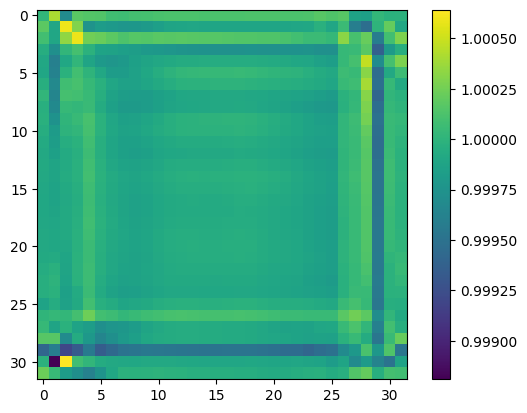

In [7]:
plt.imshow(xhat[0].permute(1,2,0).mean(-1).cpu())
plt.colorbar()

In [8]:
xhat.mean(), xhat.std()

(tensor(0.9999, device='cuda:0'), tensor(0.0003, device='cuda:0'))

In [9]:
num_steps=20
ve_sigma = lambda t: t.sqrt()
sigma_min = 0.002
sigma_max = 80
rho = 7

# Adjust noise levels based on what's supported by the network.
sigma_min = max(sigma_min, net.sigma_min)
sigma_max = min(sigma_max, net.sigma_max)

step_indices = torch.arange(num_steps, dtype=torch.float64, device="cpu")

orig_t_steps = (sigma_max ** 2) * ((sigma_min ** 2 / sigma_max ** 2) ** (step_indices / (num_steps - 1)))
sigma_steps = ve_sigma(orig_t_steps)

In [10]:
torch.sqrt(orig_t_steps)

tensor([8.0000e+01, 4.5801e+01, 2.6222e+01, 1.5012e+01, 8.5948e+00, 4.9206e+00,
        2.8171e+00, 1.6129e+00, 9.2338e-01, 5.2865e-01, 3.0266e-01, 1.7328e-01,
        9.9203e-02, 5.6795e-02, 3.2516e-02, 1.8616e-02, 1.0658e-02, 6.1018e-03,
        3.4934e-03, 2.0000e-03], dtype=torch.float64)

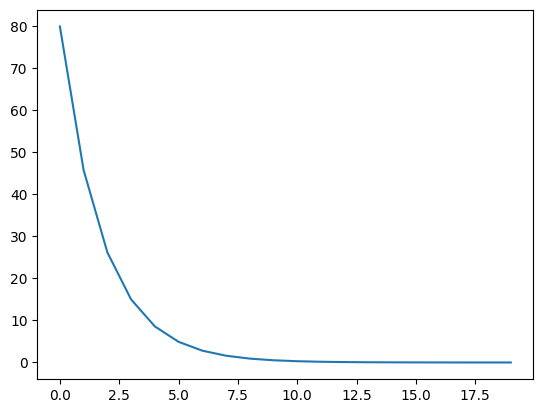

In [11]:
plt.plot(sigma_steps)


In [12]:
step_indices = torch.arange(num_steps, dtype=torch.float64, device="cpu")
t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
t_steps.shape


torch.Size([20])

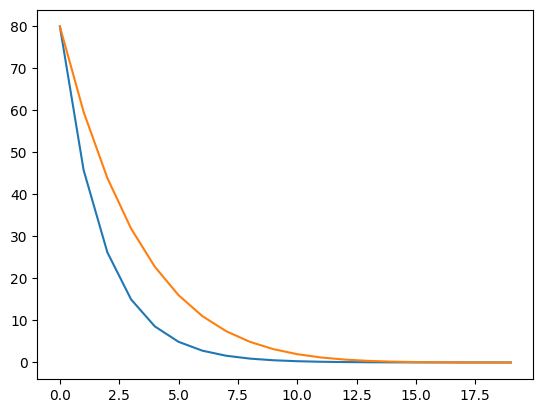

In [13]:
plt.plot(sigma_steps);
plt.plot(t_steps);

<AxesSubplot: >

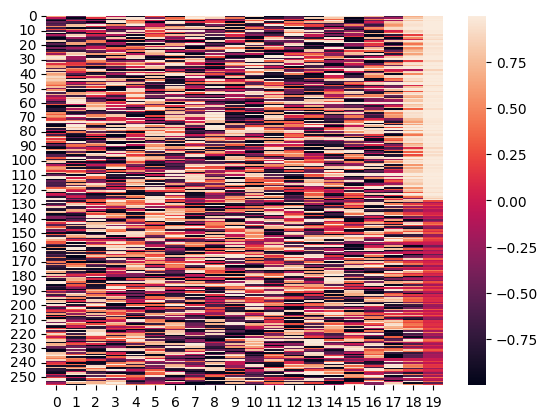

In [14]:
sns.heatmap(net.model.map_noise(t_steps.to(device)).T.cpu())

In [15]:
opts = dnnlib.EasyDict(
    data="workdir/datasets/cifar10-32x32.zip",
    xflip=False,
    augment=0.0,
    cond=False,
    cache=False,
    workers=1,
)

# Initialize config dict.
c = dnnlib.EasyDict()
c.dataset_kwargs = dnnlib.EasyDict(
    class_name="training.dataset.ImageFolderDataset",
    path=opts.data,
    use_labels=opts.cond,
    xflip=opts.xflip,
    cache=opts.cache,
)
c.data_loader_kwargs = dnnlib.EasyDict(
    pin_memory=True, num_workers=opts.workers, prefetch_factor=1,
    batch_size=32
)

# Validate dataset options.
dataset_obj = dnnlib.util.construct_class_by_name(**c.dataset_kwargs)
dataset_name = dataset_obj.name
c.dataset_kwargs.resolution = (
    dataset_obj.resolution
)  # be explicit about dataset resolution
c.dataset_kwargs.max_size = len(dataset_obj)  # be explicit about dataset size


In [17]:
from torch_utils import misc
seed=42
batch_size=4
dataset_obj = dnnlib.util.construct_class_by_name(**c.dataset_kwargs) # subclass of training.dataset.Dataset
dataset_sampler = misc.InfiniteSampler(dataset=dataset_obj, rank=0, num_replicas=1, seed=seed)
dataset_iterator = iter(torch.utils.data.DataLoader(dataset=dataset_obj, sampler=dataset_sampler, **c.data_loader_kwargs))


In [18]:
x_batch,_ = next(dataset_iterator)
x_batch = x_batch.to(device).to(torch.float32) / 127.5 - 1

In [19]:
x_batch.shape

torch.Size([32, 3, 32, 32])

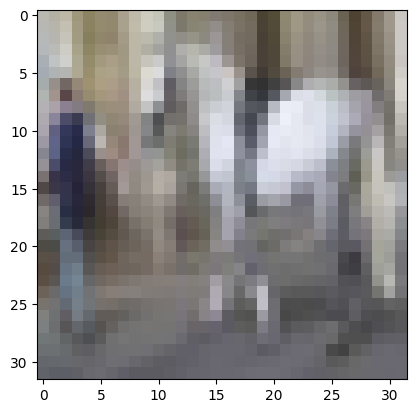

In [20]:
plt.imshow((x_batch.permute(0,2,3,1)[0].cpu() + 1) / 2)

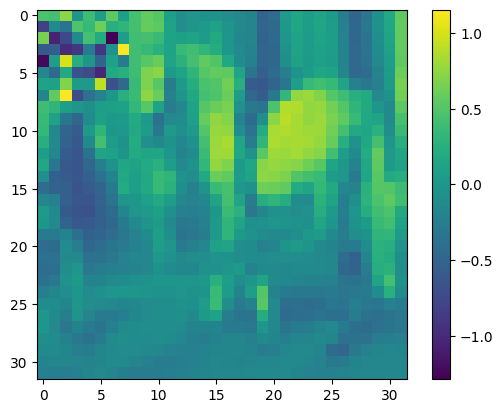

In [21]:
x_batch[0,:, :8,:8] = torch.randn(3,8,8)
xhat = net(x_batch, t)
plt.imshow(xhat[0].permute(1,2,0).mean(-1).cpu())
plt.colorbar()

In [25]:
from scorer import EDMScorer
from scorer import VEScorer

if LOAD_EDM:
    Scorer = EDMScorer
else:
    Scorer = VEScorer

score_fn = Scorer(
    net.model, sigma_min=net.sigma_min, sigma_max=net.sigma_max,
    sigma_data=net.sigma_data, # for EDM cond
)


In [26]:
net.sigma_max, net.sigma_min

(inf, 0)

In [28]:
score = score_fn(x_batch, torch.ones([1],device=device) * 80, debug=True)
score.shape

c_in: tensor([[[[3.9061e-05]]]], device='cuda:0')
c_noise: tensor([[[[1.0955]]]], device='cuda:0')
c_out: tensor([[[[0.5000]]]], device='cuda:0')


torch.Size([32, 3, 32, 32])

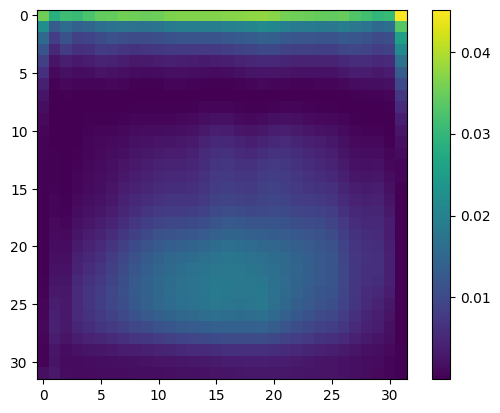

In [29]:
plt.imshow((score[0].permute(1,2,0).mean(-1).cpu())**2)
plt.colorbar()

In [30]:
c.data_loader_kwargs["batch_size"] = 64 
c.data_loader_kwargs

{'pin_memory': True, 'num_workers': 1, 'prefetch_factor': 1, 'batch_size': 64}

In [40]:
from scorer import compute_scores

scores = compute_scores(
    net,
    c.dataset_kwargs,
    c.data_loader_kwargs,
    sigma_max=80,
    sigma_min=0.02,
    model_type="edm" if LOAD_EDM else "ve",
)


tensor([8.0000e+01, 6.1650e+01, 4.7033e+01, 3.5493e+01, 2.6470e+01, 1.9490e+01,
        1.4150e+01, 1.0117e+01, 7.1127e+00, 4.9078e+00, 3.3167e+00, 2.1900e+00,
        1.4087e+00, 8.7959e-01, 5.3087e-01, 3.0806e-01, 1.7075e-01, 8.9632e-02,
        4.4072e-02, 2.0000e-02], device='cuda:0', dtype=torch.float64)


Scoring:   0%|          | 0/782 [00:00<?, ?it/s]

c_in: tensor([[[[3.9061e-05]]]], device='cuda:0')
c_noise: tensor([[[[1.0955]]]], device='cuda:0')
c_out: tensor([[[[0.5000]]]], device='cuda:0')
tensor(80., device='cuda:0', dtype=torch.float64) 0.8012647
c_in: tensor([[[[6.5772e-05]]]], device='cuda:0')
c_noise: tensor([[[[1.0304]]]], device='cuda:0')
c_out: tensor([[[[0.5000]]]], device='cuda:0')
tensor(61.6501, device='cuda:0', dtype=torch.float64) 0.45524755
c_in: tensor([[[[0.0001]]]], device='cuda:0')
c_noise: tensor([[[[0.9627]]]], device='cuda:0')
c_out: tensor([[[[0.5000]]]], device='cuda:0')
tensor(47.0330, device='cuda:0', dtype=torch.float64) 1.318935
c_in: tensor([[[[0.0002]]]], device='cuda:0')
c_noise: tensor([[[[0.8923]]]], device='cuda:0')
c_out: tensor([[[[0.5000]]]], device='cuda:0')
tensor(35.4931, device='cuda:0', dtype=torch.float64) 1.3253635
c_in: tensor([[[[0.0004]]]], device='cuda:0')
c_noise: tensor([[[[0.8190]]]], device='cuda:0')
c_out: tensor([[[[0.4999]]]], device='cuda:0')
tensor(26.4704, device='cuda:0

In [41]:
scores.shape

(64, 20, 3, 32, 32)

In [42]:
scores.reshape(64, -1).mean(1).shape

(64,)

In [43]:
import pandas as pd

recordify = lambda ds,name: [(i, sigma_steps[i].item(), x, name) for i, scores in enumerate(ds.T) for x in scores ]

records = [
    recordify(scores.reshape(64,20, -1).mean(-1), "Train"),
]
df = pd.DataFrame.from_records(sum(records, []), columns=["t", "sigma", "score", "dataset"])
df.shape

(1280, 4)

<AxesSubplot: xlabel='t', ylabel='score'>

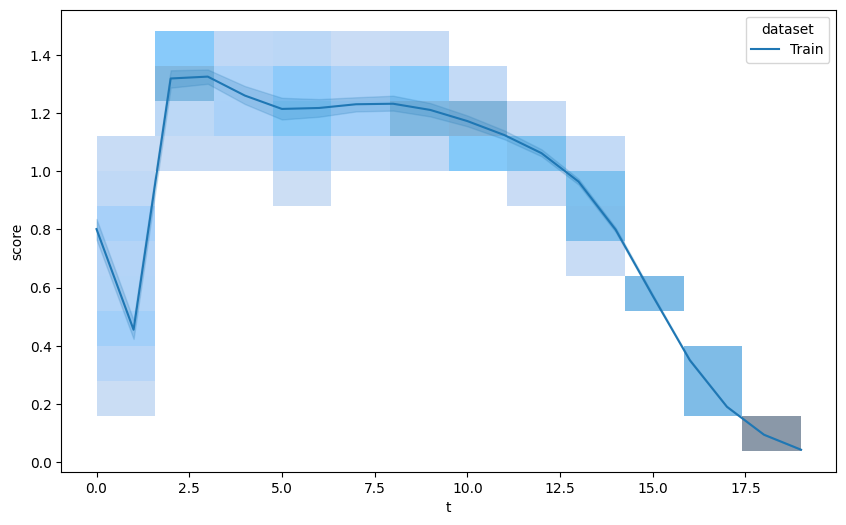

In [44]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.histplot(data=df, x="t", y="score", hue="dataset", ax=ax, alpha=0.6)
sns.lineplot(data=df, x="t", y="score", hue="dataset", errorbar=('ci', 99), ax=ax)

<AxesSubplot: xlabel='t', ylabel='score'>

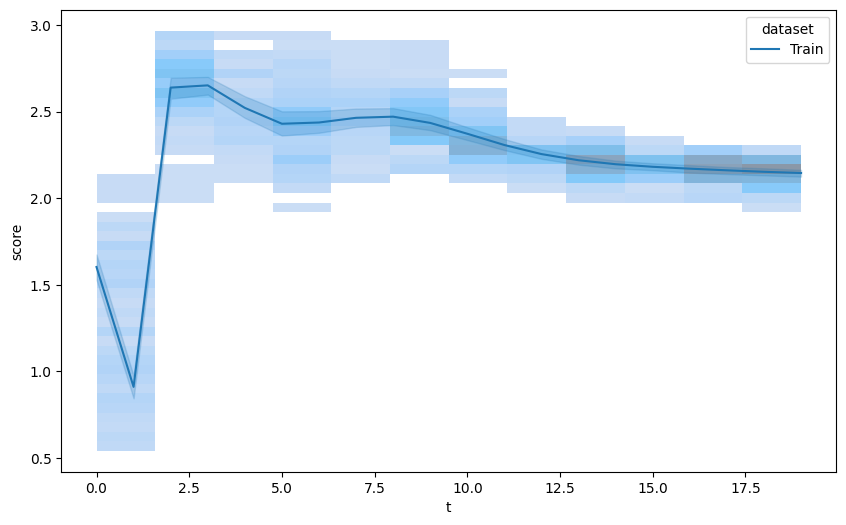

In [39]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.histplot(data=df, x="t", y="score", hue="dataset", ax=ax, alpha=0.6)
sns.lineplot(data=df, x="t", y="score", hue="dataset", errorbar=('ci', 99), ax=ax)

In [ ]:
image = scores[:,0].mean(1)**2
image.shape


(64, 32, 32)

In [ ]:
gridh=8
gridw=8
image = scores[:, 1].mean(1, keepdims=True)**2
image = image.reshape(gridh, gridw, *image.shape[1:]).transpose(0, 3, 1, 4, 2)
image = image.reshape(gridh * net.img_resolution, gridw * net.img_resolution,)
image.shape

(256, 256)

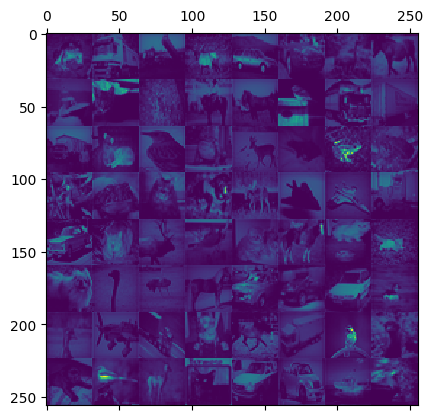

In [ ]:
plt.matshow(image)